## Using LSTM to predict Bit Coin Currency

Edited by Una
Date: 2021-07-14


#### Install packages:

> pip3 install -r requirement.txt

requirement.txt

numpy
pandas
matplotlib
sklearn
torch
seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import math, time
import torch.nn as nn
from sklearn.metrics import mean_squared_error

## 1. Loadin data and data preprocessing

normalization for close price : 

[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [2]:
### Loadin the csv data
dataset = pd.read_csv("BTC.csv", header=None, names = ["date","close","vol"], index_col=0, parse_dates=True)

In [3]:
print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1089 entries, 2017-07-23 to 2020-07-15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1089 non-null   float64
 1   vol     1089 non-null   float64
dtypes: float64(2)
memory usage: 25.5 KB
None


,close,vol
date,,
2017-07-23,2730.40,1.072840e+09
2017-07-24,2754.86,8.664740e+08
2017-07-25,2576.48,1.460090e+09
2017-07-26,2529.45,9.374040e+08
2017-07-27,2671.78,7.891040e+08


In [4]:
## Close price normalization to 0-1
scaler = MinMaxScaler()# default feature_range=(0,1)
dataset_scaled = scaler.fit_transform(dataset.close.values.reshape(-1,1))

In [5]:
## Convert the normalized close price to a vector of lookback-dimension with lookback history data
def split_data(stock, lookback):
    data = []
    for index in range(len(stock) - lookback):
        data.append(stock[index: index + lookback])

    data = np.array(data)
    train_val_slip = int(0.8* data.shape[0])


    x_train = data[:train_val_slip,:-1,:]
    y_train = data[:train_val_slip,-1,:]

    x_test = data[train_val_slip:,:-1]
    y_test = data[train_val_slip:,-1,:]

    return [x_train, y_train, x_test, y_test]

lookback = 20 
x_train, y_train, x_test, y_test = split_data(dataset_scaled, lookback)
x_train_torch = torch.from_numpy(x_train).type(torch.Tensor)
x_test_torch = torch.from_numpy(x_test).type(torch.Tensor)
y_train_torch = torch.from_numpy(y_train).type(torch.Tensor)
y_test_torch = torch.from_numpy(y_test).type(torch.Tensor)

## 2. Creat NN model

In [6]:
# 构造模型
class LSTM(nn.Module):
    # __init__定义网络中的参数和模型框架，初始化传入输入、隐藏层、输出三个参数
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()#继承__init__功能
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)#隐藏层输出
        self.fc = nn.Linear(hidden_dim, output_dim)#输出层输出

    #forward定义传输数据的连接，即网络或者模型中的走向，传入计算值的函数，正向传播输入值，神经网络分析出输出值
    def forward(self, x):
        # 用零初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # 初始化细胞单元状态
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        #detach分离，截断时间反向传播BPTT
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # out[:, -1, :]只需要最后一步的隐藏状态
        out = self.fc(out[:, -1, :])
        return out


In [7]:
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

## 3. Train the model

In [8]:
num_epochs = 100
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model(x_train_torch)

    loss = criterion(y_train_pred, y_train_torch)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.0010884853545576334
Epoch  1 MSE:  0.0010849826503545046
Epoch  2 MSE:  0.0010792349930852652
Epoch  3 MSE:  0.00107480282895267
Epoch  4 MSE:  0.0010722068836912513
Epoch  5 MSE:  0.0010679637780413032
Epoch  6 MSE:  0.0010637312661856413
Epoch  7 MSE:  0.0010611442849040031
Epoch  8 MSE:  0.0010577291250228882
Epoch  9 MSE:  0.0010539983632043004
Epoch  10 MSE:  0.0010516432812437415
Epoch  11 MSE:  0.001048924634233117
Epoch  12 MSE:  0.0010455854935571551
Epoch  13 MSE:  0.0010431524133309722
Epoch  14 MSE:  0.0010406924411654472
Epoch  15 MSE:  0.0010377130238339305
Epoch  16 MSE:  0.0010353962425142527
Epoch  17 MSE:  0.0010331737576052547
Epoch  18 MSE:  0.0010304453317075968
Epoch  19 MSE:  0.0010281003778800368
Epoch  20 MSE:  0.0010258967522531748
Epoch  21 MSE:  0.0010233311913907528
Epoch  22 MSE:  0.0010210402542725205
Epoch  23 MSE:  0.001018884708173573
Epoch  24 MSE:  0.0010164203122258186
Epoch  25 MSE:  0.0010141037637367845
Epoch  26 MSE:  0.00101190

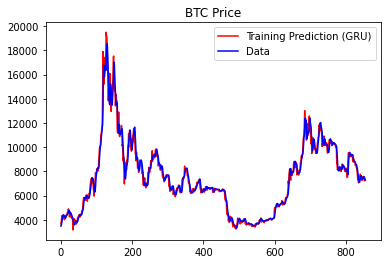

In [16]:
y_train_model = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_original = scaler.inverse_transform(y_train)

#####Visulization
plt.plot(y_train_original, color = 'red', label = 'BTC True Price')
plt.plot(y_train_model, color = 'blue', label = 'BTC predicted Price')
plt.title('BTC Price')
plt.legend(['Training Prediction (GRU)','Data'])
plt.show()

## 4. Predict on the testset

In [17]:
y_test_pred = model(x_test_torch)

y_test_model = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_original = scaler.inverse_transform(y_test)

In [18]:
# 计算实际损失
trainScore = math.sqrt(mean_squared_error(y_train_original, y_train_model))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_original, y_test_model))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 495.47 RMSE
Test Score: 383.76 RMSE


## 5. Visualization

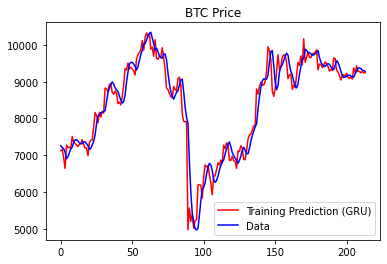

In [19]:
#####Visulization
plt.plot(y_test_original, color = 'red', label = 'BTC True Price')
plt.plot(y_test_model, color = 'blue', label = 'BTC predicted Price')
plt.title('BTC Price')
plt.legend(['Training Prediction (GRU)','Data'])
plt.show()

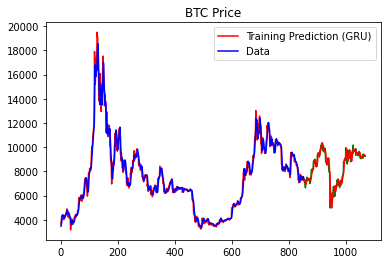

In [20]:
## Show all curve
plt.plot(y_train_original, color = 'red', label = 'BTC True Price')
plt.plot(y_train_model, color = 'blue', label = 'BTC predicted Price')
plt.title('BTC Price')
plt.legend(['Training Prediction (GRU)','Data'])

### add the x-information
N_original, N_test = len(y_train_original),len(y_test_model)
index_test = [i for i in range(0,N_test)]
index_test = np.array(index_test).reshape(-1,1) + N_original

plt.plot(index_test, y_test_original, color = 'green', label = 'BTC True Price')
plt.plot(index_test, y_test_model, color = 'red', label = 'BTC predicted Price')
plt.show()